In [22]:
import sys
from pathlib import Path
  
import numpy as np
import pandas as pd
import warnings
import torch  
from sklearn.preprocessing import StandardScaler
import optuna
import json

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Add project root directory to Python path to allow importing from src folder
notebook_dir = Path("__file__").resolve().parent
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [4]:
print(torch.cuda.is_available())

True


In [5]:
# import utils

from src.utils_classical import split_data, generate_objective, compare_classification_models
from src.utils_plotting import create_classification_report

In [6]:
# Read dataset
from src.utils_data import FEATURE_DATA_FOLDER, PLANT_CLASS_DICT
from src.utils_autoencoder import SemiSupervisedAutoencoder, create_dataloader, full_X_dataloader

feature_dataset_path: Path = FEATURE_DATA_FOLDER / "feature_dataset.csv"
df = pd.read_csv(feature_dataset_path)
df.head()

,image_filename,class_name,class_number,rgb_0_mean,rgb_0_std,rgb_0_skewness,rgb_1_mean,rgb_1_std,rgb_1_skewness,rgb_2_mean,rgb_2_std,rgb_2_skewness,hsv_0_mean,hsv_0_std,hsv_0_skewness,hsv_1_mean,hsv_1_std,hsv_1_skewness,hsv_2_mean,hsv_2_std,hsv_2_skewness,lab_0_mean,lab_0_std,lab_0_skewness,lab_1_mean,lab_1_std,lab_1_skewness,lab_2_mean,lab_2_std,lab_2_skewness,rgb_0_hist_0,rgb_0_hist_1,rgb_0_hist_2,rgb_0_hist_3,rgb_0_hist_4,rgb_0_hist_5,rgb_0_hist_6,rgb_0_hist_7,rgb_0_hist_8,rgb_0_hist_9,rgb_0_hist_10,rgb_0_hist_11,rgb_0_hist_12,rgb_0_hist_13,rgb_0_hist_14,rgb_0_hist_15,rgb_0_hist_16,rgb_0_hist_17,rgb_0_hist_18,rgb_0_hist_19,rgb_0_hist_20,rgb_0_hist_21,rgb_0_hist_22,rgb_0_hist_23,rgb_0_hist_24,rgb_0_hist_25,rgb_0_hist_26,rgb_0_hist_27,rgb_0_hist_28,rgb_0_hist_29,rgb_0_hist_30,rgb_0_hist_31,rgb_1_hist_0,rgb_1_hist_1,rgb_1_hist_2,rgb_1_hist_3,rgb_1_hist_4,rgb_1_hist_5,rgb_1_hist_6,rgb_1_hist_7,rgb_1_hist_8,rgb_1_hist_9,rgb_1_hist_10,rgb_1_hist_11,rgb_1_hist_12,rgb_1_hist_13,rgb_1_hist_14,rgb_1_hist_15,rgb_1_hist_16,rgb_1_hist_17,rgb_1_hist_18,rgb_1_hist_19,rgb_1_hist_20,rgb_1_hist_21,rgb_1_hist_22,rgb_1_hist_23,rgb_1_hist_24,rgb_1_hist_25,rgb_1_hist_26,rgb_1_hist_27,rgb_1_hist_28,rgb_1_hist_29,rgb_1_hist_30,rgb_1_hist_31,rgb_2_hist_0,rgb_2_hist_1,rgb_2_hist_2,rgb_2_hist_3,rgb_2_hist_4,rgb_2_hist_5,rgb_2_hist_6,rgb_2_hist_7,rgb_2_hist_8,rgb_2_hist_9,rgb_2_hist_10,rgb_2_hist_11,rgb_2_hist_12,rgb_2_hist_13,rgb_2_hist_14,rgb_2_hist_15,rgb_2_hist_16,rgb_2_hist_17,rgb_2_hist_18,rgb_2_hist_19,rgb_2_hist_20,rgb_2_hist_21,rgb_2_hist_22,rgb_2_hist_23,rgb_2_hist_24,rgb_2_hist_25,rgb_2_hist_26,rgb_2_hist_27,rgb_2_hist_28,rgb_2_hist_29,rgb_2_hist_30,rgb_2_hist_31,hsv_0_hist_0,hsv_0_hist_1,hsv_0_hist_2,hsv_0_hist_3,hsv_0_hist_4,hsv_0_hist_5,hsv_0_hist_6,hsv_0_hist_7,hsv_0_hist_8,hsv_0_hist_9,hsv_0_hist_10,hsv_0_hist_11,hsv_0_hist_12,hsv_0_hist_13,hsv_0_hist_14,hsv_0_hist_15,hsv_0_hist_16,hsv_0_hist_17,hsv_0_hist_18,hsv_0_hist_19,hsv_0_hist_20,hsv_0_hist_21,hsv_0_hist_22,hsv_0_hist_23,hsv_0_hist_24,hsv_0_hist_25,hsv_0_hist_26,hsv_0_hist_27,hsv_0_hist_28,hsv_0_hist_29,hsv_0_hist_30,hsv_0_hist_31,hsv_1_hist_0,hsv_1_hist_1,hsv_1_hist_2,hsv_1_hist_3,hsv_1_hist_4,hsv_1_hist_5,hsv_1_hist_6,hsv_1_hist_7,hsv_1_hist_8,hsv_1_hist_9,hsv_1_hist_10,hsv_1_hist_11,hsv_1_hist_12,hsv_1_hist_13,hsv_1_hist_14,hsv_1_hist_15,hsv_1_hist_16,hsv_1_hist_17,hsv_1_hist_18,hsv_1_hist_19,hsv_1_hist_20,hsv_1_hist_21,hsv_1_hist_22,hsv_1_hist_23,hsv_1_hist_24,hsv_1_hist_25,hsv_1_hist_26,hsv_1_hist_27,hsv_1_hist_28,hsv_1_hist_29,hsv_1_hist_30,hsv_1_hist_31,hsv_2_hist_0,hsv_2_hist_1,hsv_2_hist_2,hsv_2_hist_3,hsv_2_hist_4,hsv_2_hist_5,hsv_2_hist_6,hsv_2_hist_7,hsv_2_hist_8,hsv_2_hist_9,hsv_2_hist_10,hsv_2_hist_11,hsv_2_hist_12,hsv_2_hist_13,hsv_2_hist_14,hsv_2_hist_15,hsv_2_hist_16,hsv_2_hist_17,hsv_2_hist_18,hsv_2_hist_19,hsv_2_hist_20,hsv_2_hist_21,hsv_2_hist_22,hsv_2_hist_23,hsv_2_hist_24,hsv_2_hist_25,hsv_2_hist_26,hsv_2_hist_27,hsv_2_hist_28,hsv_2_hist_29,hsv_2_hist_30,hsv_2_hist_31,lab_0_hist_0,lab_0_hist_1,lab_0_hist_2,lab_0_hist_3,lab_0_hist_4,lab_0_hist_5,lab_0_hist_6,lab_0_hist_7,lab_0_hist_8,lab_0_hist_9,lab_0_hist_10,lab_0_hist_11,lab_0_hist_12,lab_0_hist_13,lab_0_hist_14,lab_0_hist_15,lab_0_hist_16,lab_0_hist_17,lab_0_hist_18,lab_0_hist_19,lab_0_hist_20,lab_0_hist_21,lab_0_hist_22,lab_0_hist_23,lab_0_hist_24,lab_0_hist_25,lab_0_hist_26,lab_0_hist_27,lab_0_hist_28,lab_0_hist_29,lab_0_hist_30,lab_0_hist_31,lab_1_hist_0,lab_1_hist_1,lab_1_hist_2,lab_1_hist_3,lab_1_hist_4,lab_1_hist_5,lab_1_hist_6,lab_1_hist_7,lab_1_hist_8,lab_1_hist_9,lab_1_hist_10,lab_1_hist_11,lab_1_hist_12,lab_1_hist_13,lab_1_hist_14,lab_1_hist_15,lab_1_hist_16,lab_1_hist_17,lab_1_hist_18,lab_1_hist_19,lab_1_hist_20,lab_1_hist_21,lab_1_hist_22,lab_1_hist_23,lab_1_hist_24,lab_1_hist_25,lab_1_hist_26,lab_1_hist_27,lab_1_hist_28,lab_1_hist_29,lab_1_hist_30,lab_1_hist_31,lab_2_hist_0,lab_2_hist_1,lab_2_hist_2,lab_2_hist_3,lab_2_hist_4,lab_2_hist_5,lab_2_hist_6,lab_2_hist_7,lab_2_hist_8,lab_2_hist_9,la

In [7]:
X = df.drop(columns=['class_name', 'class_number', 'image_filename'])
y = df['class_number']

print(X.info())
print(y.info())
target_names = list(PLANT_CLASS_DICT.values())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4971 entries, 0 to 4970
Columns: 371 entries, rgb_0_mean to vesselness_std
dtypes: float64(371)
memory usage: 14.1 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 4971 entries, 0 to 4970
Series name: class_number
Non-Null Count  Dtype
--------------  -----
4971 non-null   int64
dtypes: int64(1)
memory usage: 39.0 KB
None


In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize features

X_labeled, X_unlabeled, y_labeled, _ = split_data(X_scaled, y.to_numpy(), test_size=0.80)
y_labeled -= y_labeled.min()

unlabeled_loader, labeled_loader = create_dataloader(X_labeled, X_unlabeled, y_labeled)

In [ ]:
# Initilize autoencoder
autoencoder = SemiSupervisedAutoencoder(input_dim=X.shape[1], encoding_dim=50, num_classes=len(set(y)))

# Load the weights
autoencoder.autoencoder.load_state_dict(torch.load("../models/autoencoder_weights.pth"))

<All keys matched successfully>

In [14]:
# Create a DataLoader for the data you want to extract features from
full_dataloader = full_X_dataloader(X_scaled)

# Extract latent features
reduced_features = autoencoder.extract_features(full_dataloader).numpy()

print("Latent features shape:", reduced_features.shape)

Extracted features shape: torch.Size([4971, 50])
Latent features shape: (4971, 50)


In [16]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# models dictionary top 3 models
models = {
    'Support Vector Machine - rbf': SVC(kernel='rbf'),
    'Support Vector Machine - linear': SVC(kernel='linear'),
    'Support Vector Machine - poly': SVC(kernel='poly'),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}


results = compare_classification_models(reduced_features, y, models)
print(results.to_markdown(index=False))

Completed Support Vector Machine - rbf: Mean Accuracy = 0.9622
Completed Support Vector Machine - linear: Mean Accuracy = 0.9501
Completed Support Vector Machine - poly: Mean Accuracy = 0.9543
Completed k-Nearest Neighbors: Mean Accuracy = 0.9519
Completed MLP Classifier: Mean Accuracy = 0.9509
| Model                           |   Accuracy |
|:--------------------------------|-----------:|
| Support Vector Machine - rbf    |   0.96218  |
| Support Vector Machine - poly   |   0.954334 |
| k-Nearest Neighbors             |   0.95192  |
| MLP Classifier                  |   0.950915 |
| Support Vector Machine - linear |   0.950111 |


In [ ]:
models = {
    'Support Vector Machine': SVC(kernel='rbf'),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Example search spaces for hyperparameters
search_spaces = {
    'Support Vector Machine': {
        'C': (0.1, 10.0),  # Float range for C
        'gamma': (0.01, 1.0)  # Float range for gamma
    },
    'k-Nearest Neighbors': {
        'n_neighbors': list(range(1, 30)),  # Integer range for n_neighbors
        'weights': ['uniform', 'distance']  # Categorical
    },
    'MLP Classifier': {
        'alpha': (0.0001, 0.01),  # Float range for alpha
        'learning_rate_init': (0.001, 0.1)  # Float range for learning rate
    }
}

# Store optimized models and study results
optimized_models = {}
studies = {}

# Loop through each model and optimize using Optuna
for model_name, model in models.items():
    print(f"Optimizing {model_name}...")
    
    # Generate the search space for the current model
    search_space = search_spaces[model_name]
    
    # Generate the Optuna objective function
    objective = generate_objective(reduced_features, y, model, search_space, 'accuracy')
    
    # Create and optimize the study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50, timeout=600)
    
    # Save the best model and study
    optimized_models[model_name] = model.set_params(**study.best_params)
    studies[model_name] = study

    print(f"Best parameters for {model_name}: {study.best_params}")
    print(f"Best score for {model_name}: {study.best_value}")


[I 2024-11-30 03:10:06,636] A new study created in memory with name: no-name-1f2a866f-7465-44fa-9cf9-ade909581f18


Optimizing Support Vector Machine...


[I 2024-11-30 03:10:12,215] Trial 0 finished with value: 0.32870833038431596 and parameters: {'C': 7.70571219014803, 'gamma': 0.7267654256607321}. Best is trial 0 with value: 0.32870833038431596.
[I 2024-11-30 03:10:17,746] Trial 1 finished with value: 0.4017326066954491 and parameters: {'C': 9.46128808351196, 'gamma': 0.6551684749440742}. Best is trial 1 with value: 0.4017326066954491.
[I 2024-11-30 03:10:23,138] Trial 2 finished with value: 0.5968619758753526 and parameters: {'C': 7.566100804844914, 'gamma': 0.4972808383567589}. Best is trial 2 with value: 0.5968619758753526.
[I 2024-11-30 03:10:28,648] Trial 3 finished with value: 0.362103070685419 and parameters: {'C': 1.9601877868453155, 'gamma': 0.6921045043838583}. Best is trial 2 with value: 0.5968619758753526.
[I 2024-11-30 03:10:34,941] Trial 4 finished with value: 0.30557293509802536 and parameters: {'C': 7.629172147073338, 'gamma': 0.7574070599953897}. Best is trial 2 with value: 0.5968619758753526.
[I 2024-11-30 03:10:39,8

Best parameters for Support Vector Machine: {'C': 4.272393163775447, 'gamma': 0.015551478368052644}
Best score for Support Vector Machine: 0.9704269840146406
Optimizing k-Nearest Neighbors...


[I 2024-11-30 03:13:32,934] Trial 2 finished with value: 0.9233554088349191 and parameters: {'n_neighbors': 20, 'weights': 'uniform'}. Best is trial 1 with value: 0.9342175667067734.
[I 2024-11-30 03:13:32,996] Trial 3 finished with value: 0.9241594289354216 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 1 with value: 0.9342175667067734.
[I 2024-11-30 03:13:33,054] Trial 4 finished with value: 0.9132970688452321 and parameters: {'n_neighbors': 25, 'weights': 'uniform'}. Best is trial 1 with value: 0.9342175667067734.
[I 2024-11-30 03:13:33,123] Trial 5 finished with value: 0.9241594289354216 and parameters: {'n_neighbors': 19, 'weights': 'uniform'}. Best is trial 1 with value: 0.9342175667067734.
[I 2024-11-30 03:13:33,180] Trial 6 finished with value: 0.9511157396641154 and parameters: {'n_neighbors': 7, 'weights': 'distance'}. Best is trial 6 with value: 0.9511157396641154.
[I 2024-11-30 03:13:33,250] Trial 7 finished with value: 0.9324069037339615 and param

Best parameters for k-Nearest Neighbors: {'n_neighbors': 4, 'weights': 'uniform'}
Best score for k-Nearest Neighbors: 0.9553410917767915
Optimizing MLP Classifier...


[I 2024-11-30 03:13:37,038] Trial 0 finished with value: 0.9223501814909557 and parameters: {'alpha': 0.005651845733943809, 'learning_rate_init': 0.030659808691053086}. Best is trial 0 with value: 0.9223501814909557.
[I 2024-11-30 03:13:37,922] Trial 1 finished with value: 0.9143043183725469 and parameters: {'alpha': 0.008574055859781389, 'learning_rate_init': 0.07205913866860489}. Best is trial 0 with value: 0.9223501814909557.
[I 2024-11-30 03:13:38,779] Trial 2 finished with value: 0.8919709210034072 and parameters: {'alpha': 0.003441048080389838, 'learning_rate_init': 0.09527329816283857}. Best is trial 0 with value: 0.9223501814909557.
[I 2024-11-30 03:13:39,573] Trial 3 finished with value: 0.9110827780754882 and parameters: {'alpha': 0.0036049253897329006, 'learning_rate_init': 0.06327499698695649}. Best is trial 0 with value: 0.9223501814909557.
[I 2024-11-30 03:13:40,673] Trial 4 finished with value: 0.9301926129642176 and parameters: {'alpha': 0.0016940131568958668, 'learning

Best parameters for MLP Classifier: {'alpha': 0.004114900391312138, 'learning_rate_init': 0.009602166136214958}
Best score for MLP Classifier: 0.9587604016056135


In [28]:
# Extract and save model parameters to JSON
model_parameters = {model_name: model.get_params() for model_name, model in optimized_models.items()}

with open("../models/optimized_model_parameters.json", 'w') as f:
    json.dump(model_parameters, f)

print("Successfully saved parameters!")

Successfully saved parameters!


In [20]:
results = compare_classification_models(reduced_features, y, optimized_models)
print(results.to_markdown(index=False))

Completed Support Vector Machine: Mean Accuracy = 0.9704
Completed k-Nearest Neighbors: Mean Accuracy = 0.9553
Completed MLP Classifier: Mean Accuracy = 0.9588
| Model                  |   Accuracy |
|:-----------------------|-----------:|
| Support Vector Machine |   0.970427 |
| MLP Classifier         |   0.95876  |
| k-Nearest Neighbors    |   0.955341 |


                         precision    recall  f1-score   support

 Hibiscus rosa-sinensis       0.97      0.95      0.96        37
        Psidium guajava       1.00      0.93      0.96        40
       Antidesma bunius       0.88      0.91      0.90        47
          Vitex negundo       0.98      0.95      0.97        44
       Moringa oleifera       0.98      0.96      0.97        49
     Blumea balsamifera       0.91      1.00      0.96        32
       Origanum vulgare       0.93      0.95      0.94        41
     Pepromia pellucida       0.94      0.97      0.96        34
      Centella asiatica       0.96      1.00      0.98        51
 Coleus scutellarioides       1.00      1.00      1.00        38
     Phyllanthus niruri       1.00      0.97      0.99        35
    Corchorus olitorius       0.96      0.92      0.94        51
    Momordica charantia       1.00      0.97      0.99        36
        Euphorbia hirta       0.97      0.95      0.96        41
          Curcuma longa 

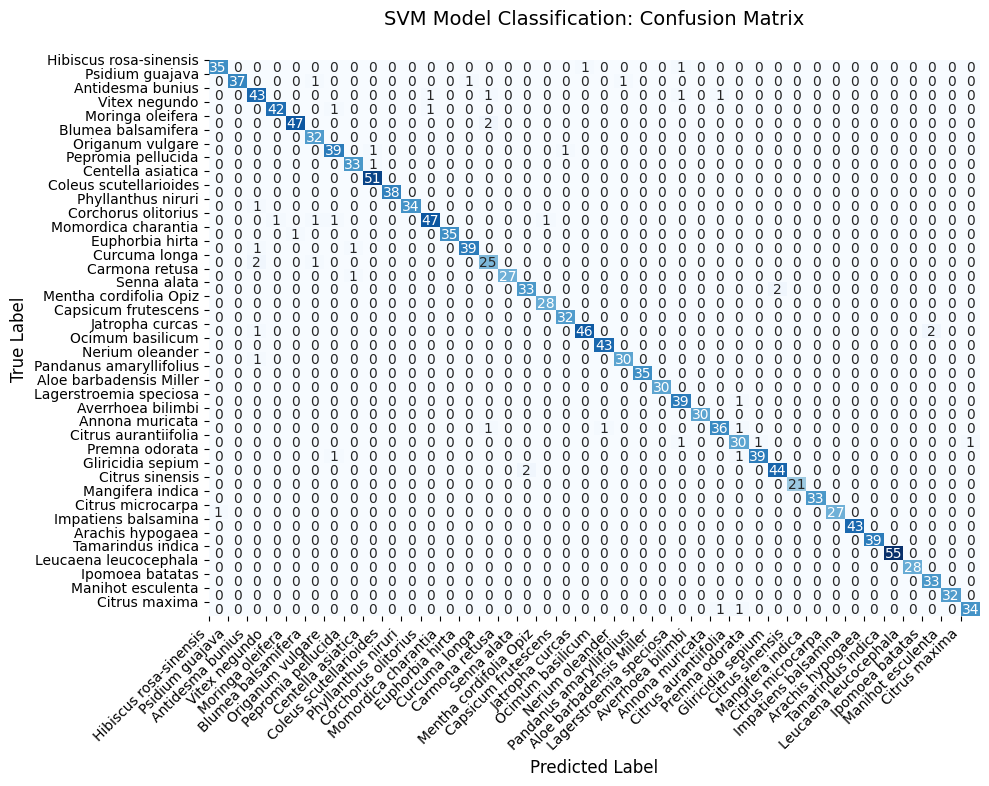

In [35]:
X_train, X_test, y_train, y_test = split_data(reduced_features, y)

model = optimized_models['Support Vector Machine']
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
create_classification_report(y_test, y_pred, target_names, "SVM Model Classification")